In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetBidimensionalMulticlasse(n=20, n_classes=3):
    """
    Cria um dataset bidimensional mnulticlasse.
    """
    X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0, 1.0), cluster_std=0.02)
    return X, y

n_classes = 3
X, y = criaDatasetBidimensionalMulticlasse(1000, n_classes)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

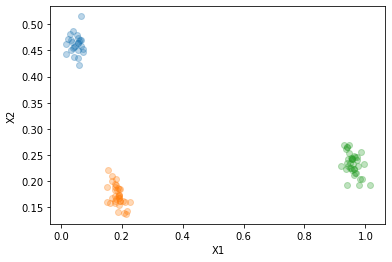

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

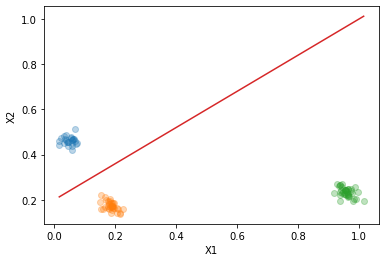

In [3]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    """
    Plota um definido por um
    vetor e o valor em que este vetor 
    intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([4, 5]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [4]:
def sign(a):
    return (a >= 0) * 2 - 1

In [5]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [6]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [7]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass

class DescidaGradiente(TrainingAlgorithm):
    def __init__(self, max_iter=1000, learning_rate=0.005, 
                       regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.cost = cost

    def getW(self, X, y):
        w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.max_iter):
            ypred = X @ w
            if self.cost.custo(y, ypred) == 0:
                break
            w *= 1 - self.regularization * self.learning_rate
            w += self.cost.gradiente(y, ypred, X) * self.learning_rate
        return w

In [8]:
a = np.ones((4,))
len(a.shape)

1

1.0
[[ -3.43003452   6.31365317  -6.22533177]
 [ -9.53106556  -6.32837612  11.79840189]
 [ 13.83346465 -17.57128982  -1.80948252]]


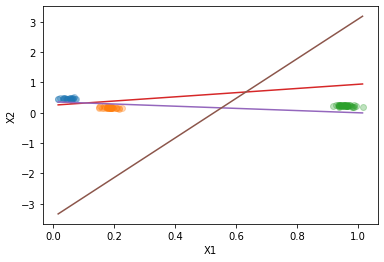

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class Perceptron(BaseEstimator, ClassifierMixin):
    """
    Versão do Perceptron multiclasse.
    """
    def __init__(self, training_algrithm=DescidaGradiente()):
        self.w = None
        self.training_algorithm = training_algrithm
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        Xb = Perceptron.includebias(X)
        yhot = self.encode_labels(y)
        self.w = self.training_algorithm.getW(Xb, yhot)
    
    def __pre_activation(self, X):
        Xb = Perceptron.includebias(X)
        return np.matmul(Xb, self.w)

    def predict(self, X):
        a = self.__pre_activation(X)
        idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

perceptron = Perceptron(training_algrithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)
for i in range(perceptron.w.shape[0]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])



1.0 1.0
[[-1.97831473  2.63606098 -1.65729187]
 [-0.54407378 -1.94368096  2.48758143]
 [ 6.42175477 -7.58147024  1.15833997]]


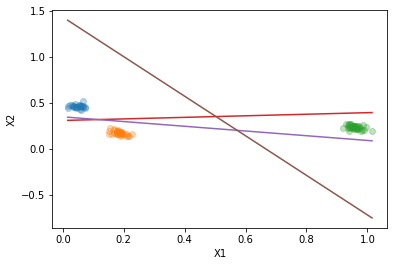

1.0 1.0
[[ 0.02065391  0.33465303 -0.38986415]
 [-0.9676492  -0.89453873  0.82031243]
 [ 0.50657954 -0.72752419  0.50170621]]


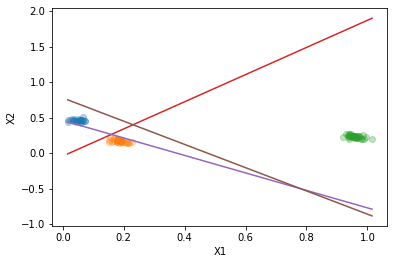

1.0 1.0
[[ -1.67118427   3.69551441  -1.52678701]
 [ -5.03463925  -2.83721653   3.007186  ]
 [  7.02699471 -10.57473433  -0.98152373]]


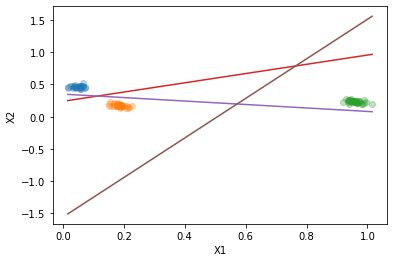

1.0 1.0
[[ -3.30291825   6.22536603  -6.21296432]
 [ -9.82594616  -6.26730243  11.79279063]
 [ 13.54174258 -17.31540132  -1.85226949]]


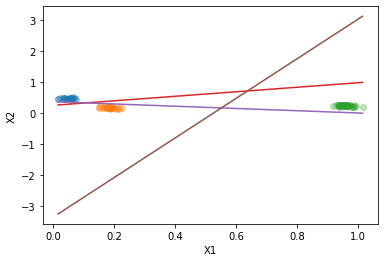

In [10]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algrithm=DescidaGradiente(regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)))
    print(perceptron.w)
    plotaDatasetBidimensional(Xtr, ytr)
    for i in range(perceptron.w.shape[0]):
        plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])
    plt.show()
